# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных

Признаки
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак
* `Price` — цена (евро)

## Подготовка данных

In [1]:
!pip install scikit-learn --upgrade

                                              0.0/9.3 MB ? eta -:--:--
                                              0.0/9.3 MB ? eta -:--:--
                                              0.0/9.3 MB ? eta -:--:--
                                              0.0/9.3 MB ? eta -:--:--
                                              0.0/9.3 MB 262.6 kB/s eta 0:00:36
                                              0.0/9.3 MB 217.9 kB/s eta 0:00:43
                                              0.1/9.3 MB 353.1 kB/s eta 0:00:27
                                              0.1/9.3 MB 450.6 kB/s eta 0:00:21
                                              0.1/9.3 MB 500.5 kB/s eta 0:00:19
                                              0.2/9.3 MB 535.8 kB/s eta 0:00:18
                                              0.2/9.3 MB 529.7 kB/s eta 0:00:18
     -                                        0.3/9.3 MB 542.5 kB/s eta 0:00:17
     -                                        0.3/9.3 MB 553.0 kB/s eta 0:00

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

In [4]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

### Обзор данных

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Очень много пропусков в столбце `Repaired`. Также пропуски есть в столбцах `VehicleType, Gearbox, Model, FuelType`.  
Столбцы `DateCrawled, DateCreated, LastSeen` нужно перевести в тип `date`.

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Столбец `Price` содержит нулевые значения. Вряд ли машину отдали бесплатно ,это пропуск значения.  
Столбцы `RegistrationYear и Power` содержат неадекватные выбросы, судя по минимальному и максимальному значению.  
Столбец `Kilometer` наполовину заполнен значением `150000`. Скорее всего это в некотором роде категориальный признак и при заполнении анкеты выбирались варианты вроде `менее 5000, ..., менее 125000, менее 150000`.  
Столбец `RegistrationMonth` содержит и число 0 и число 12. Вряд ли месяца нумеруются с нуля, значит ноль это пропуск значения.
Столбец `NumberOfPictures` содержит только нули. Столбец совершенно бесполезный.   
Столбец `PostalCode` стоит рассматривать скорее как строку, а не как число. Впрочем, эти данные вообще стоит исключить при обучении, так как они не влияют на цену авто.

### Изменение столбцов

В первую очередь переведём названия столбцов к змеиному типу

In [8]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

C:\Users\Emiliia\AppData\Local\Temp\ipykernel_3752\2554096034.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Обработать нужно только столбцы с датами.

In [9]:
date_columns = ['date_crawled', 'date_created', 'last_seen']
for column in date_columns:
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [10]:
data.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

### Удаление неинформативных парметров

Рассмотрим все параметры и их описание:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

`DateCrawled, LastSeen` никак не относятся к машине и её цене, эти столбцы можно удалить.   
`DateCreated` можно разбить на два столбца: год и месяц. Так же как уже сделано с датой регистрации автомобиля. День размещения объявления вряд ли сильно влияет на цену.  
`NumberOfPictures` пустой столбец, содержащий только нули, можно удалить. Вероятно эти зачения при скачивании базы по какой-то причине были неверно обработаны. Также при  предварительной оценке авто пользователь не загружает фотографии и при предсказании это значение тоже всегда будет нулевым.     
`PostalCode` мог бы иметь смысл, если бы можно было узнать город продажи авто. Например, цены в Москве и Владивостоке будут сильно отличаться. Судя по тому, что индексы пеятизначные, а цены в евро, данные взяты где-то в Европе. Так как страну мы не знаем, то и город определить невозможно. Поэтому эти данные использовать нельзя и столбец стоит удалить. 
`RegistrationMonth` не особо будет влиять на цену продажи автомобиля, этот столбец можно удалить.

Сначала разделим столбец `DateCreated` на `CreatedYear, CreatedMonth`.

In [11]:
data['created_year'] = data['date_created'].dt.year
data['created_month'] = data['date_created'].dt.month

In [12]:
data.loc[0:2,['date_created','created_year','created_month']]

,date_created,created_year,created_month
0,2016-03-24,2016,3
1,2016-03-24,2016,3
2,2016-03-14,2016,3


Теперь можно удалить неинформативные столбцы.

In [13]:
delete_columns = ['date_created', 'date_crawled', 'last_seen','number_of_pictures', 'postal_code', 'registration_month']
data = data.drop(delete_columns, axis=1)

In [14]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'created_year',
       'created_month'],
      dtype='object')

### Обработка пропусков

In [15]:
#Запомним длину нашего датасета
len = data.shape[0]

Посмотрим долю пропусков в столбцах и попытаемся их обработать.

In [16]:
(data.isna().sum().sort_values(ascending=False) / len).round(2)

repaired             0.20
vehicle_type         0.11
fuel_type            0.09
gearbox              0.06
model                0.06
price                0.00
registration_year    0.00
power                0.00
kilometer            0.00
brand                0.00
created_year         0.00
created_month        0.00
dtype: float64

In [17]:
null_columns = ['repaired','vehicle_type','fuel_type','gearbox','model']
for column in null_columns:
    print(column)
    display(data[column].value_counts())
    print()

repaired


no     247161
yes     36054
Name: repaired, dtype: int64


vehicle_type


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64


fuel_type


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64


gearbox


manual    268251
auto       66285
Name: gearbox, dtype: int64


model


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

Быстро восстановить какие-то из этих данных нельзя. Конечно, по модели, например, можно узнать тип кузова, но это займёт много времени.  
Пропуск в столбце `repaired` лучше заменить на значение `unknown`. Так как пропусков слишком много и удалить эти строки нельзя. А само значение слишком важное, чтобы заполнить его каким-то другим образом.   
Во всех остальных столбцах, кроме `gearbox` есть вариант `other`, к которому можно отнести наши пропуски. Однако, это будет неверным значением, так что лучше так не делать. Все пропуски лучше заменить на `unknown`.  

Достаточно мало пропусков, чтобы удалить строки, в столбцах `model` и `gearbox`.   
Модель является очень важным признаком и выбор автомобиля часто основывается именно на модели. С другой стороны второй по популярности моделью является `other`, вероятно туда попали очень редкие модели автомобилей. Хоть для обучения `other` не сильно отличается от `unknown`, так как в обоих случаях мы не знаем модель авто, однако для `other` мы хотя бы можем быть уверены, что реальная модель авто не встречается в списке представленных моделей.   
Как итог, эти пропуски всё же стоит удалить.   
Тип коробки передач также является очень важным при выборе авто. Стоит посмотреть сколько строк содержат пропуск с модели или типе коробки передач и после этого решить, удалять ли их.

In [18]:
# считаем долю пропусков по двум столбцам Model и Gearbox
nans = data.loc[(data['model'].isna()) | (data['gearbox'].isna()),['model','gearbox']].shape[0]
round(nans / len, 4)

0.0999

Почти 10%, довольно много. Так как нам ещё предстоит устранение дубликатов и выбросов, лучше всё же удалить пропуски только в моделях.  
Но сначала заполним пропуски в других столбцах.

In [19]:
fillna_columns = ['repaired','vehicle_type','fuel_type', 'gearbox', 'model']
data[fillna_columns] = data[fillna_columns].fillna('unknown')

In [21]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
created_year         0
created_month        0
dtype: int64

In [22]:
round(1 - data.shape[0] / len, 2)

0.0

На этом этапе мы потеряли 6% данных.

### Устранение дубликатов

Я заметила неявный дубликат в столбце `fuel_type`: `petrol` и `gasoline` это одно и то же. Объединим всё значением `petrol`.

In [23]:
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')

Также неявные дубликаты могут быть в столбцах `model` и `brand`. Проверим их.

In [24]:
np.sort(data['model'].unique())

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [25]:
print(data[data['model']=='m_reihe']['brand'].unique())
print(data[data['model']=='m_klasse']['brand'].unique())

['bmw']
['mercedes_benz']


In [26]:
print(data[data['model']=='s_klasse']['brand'].unique())
print(data[data['model']=='s_type']['brand'].unique())

['mercedes_benz']
['jaguar']


In [27]:
print(data[data['model']=='x_reihe']['brand'].unique())
print(data[data['model']=='x_trail']['brand'].unique())
print(data[data['model']=='x_type']['brand'].unique())

['bmw']
['nissan']
['jaguar']


Похожие по названию модели относятся к разным маркам. Дубликатов нет.

In [28]:
np.sort(data['brand'].unique())

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Тут также нет дубликатов.  
Можно искать явные дубликаты.

In [29]:
data.duplicated().sum()

39372

Довольно много дубликатов. Интересно, сколько их было до удаления ненужных столбцов? Возможно некоторые данные скачивались по два раза.  

In [30]:
data = data.drop_duplicates().reset_index(drop=True)

In [31]:
data.duplicated().sum()

0

In [32]:
round(1 - data.shape[0] / len, 2)

0.11

После этого этапа мы удалили суммарно 16% данных (с учётом предыдущего этапа).

### Устранение выбросов

Вспомним, какие столбцы нам следует проверить на выбросы.

In [33]:
data.describe()

,price,registration_year,power,kilometer,created_year,created_month
count,314997.000000,314997.000000,314997.000000,314997.000000,314997.000000,314997.000000
mean,4475.489189,2004.321892,110.858681,127395.372019,2015.999927,3.169313
std,4557.941692,91.725928,199.303791,38414.009743,0.008908,0.384012
min,0.000000,1000.000000,0.000000,5000.000000,2014.000000,1.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,2016.000000,3.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,2016.000000,3.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,2016.000000,3.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,2016.000000,12.000000


Со столбцами `kilometer, created_year, created_month` всё в порядке. Остальные рассмотрим по отдельности.

#### Столбец price

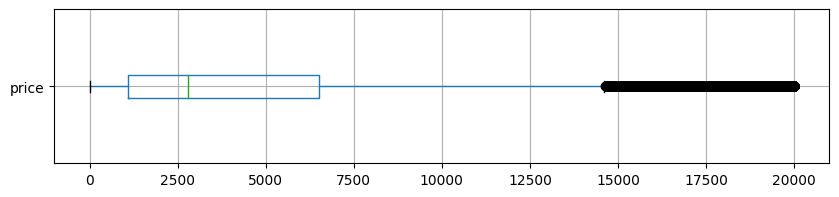

In [34]:
data[['price']].boxplot(vert = False, figsize=(10,2));

В первую очередь избавимся от нулевых цен, так как это неявные попуски.

In [35]:
round(data[(data['price']==0)]['price'].count() / len, 2)

0.03

Целых 2%, но это целевой признак, от пропусков точно надо избавиться.

Теперь посмотрим на очень маленькие значения цены.

In [36]:
round(data[(data['price'] > 0) & (data['price'] < 50)]['price'].count() / len, 3)

0.004

In [37]:
data[data['price'] < 5].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,created_year,created_month
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,2016,3
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown,2016,3
59,1,suv,1994,manual,286,unknown,150000,unknown,sonstige_autos,unknown,2016,3
89,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no,2016,3
111,0,unknown,2017,manual,0,golf,5000,petrol,volkswagen,unknown,2016,3


Вряд ли эти машины были проданы за один евро. Можно предположить, что на самом цена была одна тысяча евро.  
Таким образом можно было бы восстановить некоторые значения. Однако выше я подсчитала что машин дешевле 50 евро всего 0.3%. От такого количества лучше просто избавиться, так как цена это целевой признак и нам стоит быть уверенными, что она указана верно.

In [38]:
round(data[(data['price'] > 15000)]['price'].count() / len, 3)

0.039

Дорогих машин довольно много: 3.8%. Так как стоимость дорогих машин не слишком сильно отличается от основной массы машин, то я их оставлю. 

In [39]:
data = data.loc[data['price'] > 50]
round(data.shape[0] / len, 2)

0.86

После этого этапа мы удалили суммарно 19% данных (с учётом предыдущих этапов).

#### Столбец registration_year

Сразу выкинем все значения меньше 1900 и больше 2023.

In [40]:
data.loc[(data['registration_year'] < 1900) | (data['registration_year'] > 2023), 'price'].count() 

120

In [41]:
data = data.loc[(data['registration_year'] >= 1900) & (data['registration_year'] <= 2023)]

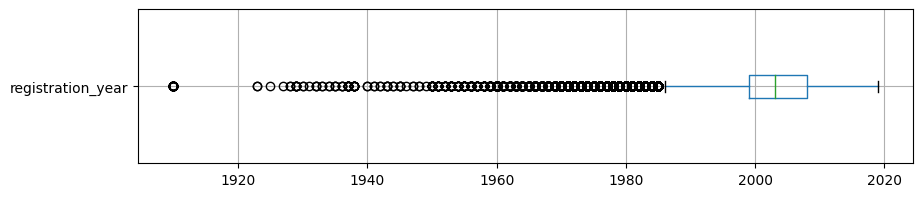

In [42]:
data[['registration_year']].boxplot(vert = False, figsize=(10,2));

In [43]:
round(data.loc[(data['registration_year'] < 1985), 'price'].count() / len, 3)

0.013

Значения до 1985 года лучше удалить. В нашем датасете их всего 1%.

In [44]:
data = data.loc[(data['registration_year'] > 1985)]
round(data.shape[0] / len, 2)

0.84

После этого этапа мы суммарно удалили 20% данных (учитывая предыдущие этапы).

#### Столбец power		

Машина с реальной мощностью более 700 л.с. должна быть очень дорогой, посмотрим есть ли такие.

In [45]:
data.loc[(data['power'] > 700) & (data['price'] > 15000)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,created_year,created_month
44061,15800,convertible,2014,auto,10218,fortwo,30000,petrol,smart,unknown,2016,4
81150,18550,sedan,2013,manual,1288,c_klasse,90000,petrol,mercedes_benz,no,2016,3
209538,15499,wagon,2012,manual,13636,c_klasse,125000,petrol,mercedes_benz,no,2016,3


Быстрый поиск в интернете даёт нам простое решение.  
У первой и третьей строки мощнось выше в 100 раз, а у второй в 10 раз.  
Можно смело все значения от 700 до 7000 делить на 10, а всё что выше 7000 на 100.  
Возможно где-то останутся неверные значения, но этот столбец не так важен как цена.

In [46]:
def divide_power(power):
    if power < 0: 
        raise ValueError("power must be greater than 0")
    if power < 700:
        return power
    if power < 7000:
        return power / 10
    return power / 100

In [47]:
data['power'] = data['power'].apply(divide_power)

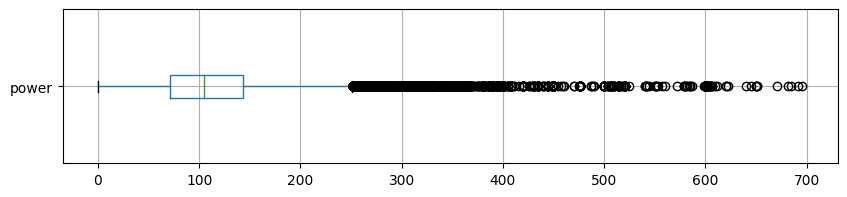

In [48]:
data[['power']].boxplot(vert = False, figsize=(10,2));

In [49]:
round(data.loc[(data['power'] == 0),'price'].count() / len, 2)

0.09

Очень много нулевых значений. Составим таблицу медианных значений мощности по марке и модели авто и заполним этим значением нули.

In [50]:
power = data[data['power'] > 0].groupby(['brand','model']).median()['power']

In [51]:
data.loc[data['power'] == 0,'power'] = data[data['power'] == 0].apply(
    lambda row : power.loc[row['brand'], row['model']], axis = 1)

Теперь можно удалить оставшиеся выбросы. 

In [52]:
round(data.loc[(data['power'] < 20) | (data['power'] > 700),'price'].count() / len, 4)

0.0008

In [53]:
data = data.loc[(data['power'] >= 20) & (data['power'] <= 700)]
round(data.shape[0] / len, 2)

0.84

После этого этапа мы суммарно удалили 22% данных (учитывая предыдущие этапы).

### Корреляция данных

In [54]:
data.corr().style.background_gradient(cmap='coolwarm',axis=0)

,price,registration_year,power,kilometer,created_year,created_month
price,1.000000,0.470482,0.499552,-0.356317,-0.005812,0.010571
registration_year,0.470482,1.000000,0.075718,-0.293507,-0.001094,-0.001815
power,0.499552,0.075718,1.000000,0.105325,-0.001035,-0.000458
kilometer,-0.356317,-0.293507,0.105325,1.000000,0.005598,0.003065
created_year,-0.005812,-0.001094,-0.001035,0.005598,1.000000,-0.135532
created_month,0.010571,-0.001815,-0.000458,0.003065,-0.135532,1.000000


Цена коррелирует с годом регистрации авто и мощностью двигателя, обратно коррелирует с пробегом.  
Между собой у признаков сильной корреляции нет, это хорошо.

### Вывод

Из датасета были удалены неинформативные столбцы: `date_crawled, last_seen, number_of_pictures, postal_code, registration_month`.  
Столбец `date_created` был заменён на год и месяц создания объявления.  

Все пропуски были заменены на `unknown`.  

Неявных дубликатов обнаружено не было.  
Явные дубликаты были удалены, они составляли примерно 10% данных.  

Строки с нулевой ценой были удалены. Они составляли примерно 2% данных.  
Строки с выбросами года регистрации были удалены. Они составляли примерно 1% данных.   
Некоторые выбросы значений мощности были обработаны путём изменения порядка значений. Нулевые значения были заменены на медианные по марке и модели. Прочие выбросы были удалены. Они составляли примерно 2% данных.   

Суммарно при обработке данных было удалено примерно 16% данных. Однако больше половины из них это дубликаты.

## Обучение моделей

### Разделение на выборки

In [55]:
random_state = 12345
target = 'price'
x = data.drop(target, axis=1)
y = data[target]

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)

In [57]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=random_state)

In [58]:
print('train:', x_train.shape, y_train.shape)
print('valid:', x_valid.shape, y_valid.shape)
print('test:', x_test.shape, y_test.shape)

train: (179004, 11) (179004,)
valid: (59669, 11) (59669,)
test: (59669, 11) (59669,)


До финального теста тестовые данные трогать не будем.  
Для большинства моделей нужно закодировать категориальные данные. Для этого используем OrdinalEncoder и OneHotEncoder.

In [59]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(x_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [60]:
x_train_oe = encoder.transform(x_train)
x_valid_oe = encoder.transform(x_valid)
x_test_oe = encoder.transform(x_test)

In [61]:
enc = OneHotEncoder(handle_unknown='infrequent_if_exist')
enc.fit(x_train)

OneHotEncoder(handle_unknown='infrequent_if_exist')

In [62]:
x_train_ohe = enc.transform(x_train)
x_valid_ohe = enc.transform(x_valid)
x_test_ohe = enc.transform(x_test)

### Модель LightGBM

In [63]:
num_leavess = [20, 50, 100]
max_depths = [10, 20, 50]
n_estimatorss = [500, 1000, 1500]
lgbm_models = []

In [64]:
for num_leaves in num_leavess:
    for max_depth in max_depths:
        for n_estimators in n_estimatorss:
            start = time.time()
            model = LGBMRegressor(num_leaves=num_leaves, 
                                  max_depth=max_depth,
                                  n_estimators=n_estimators,
                                  random_seed=random_state)
            model.fit(x_train_oe, y_train,verbose=0)
            end = time.time()
            fit_time = end - start
            start = time.time()
            prediction = model.predict(x_valid_oe)
            rmse = mean_squared_error(y_valid, prediction) ** 0.5
            end = time.time()
            predict_time = end - start
            lgbm_models.append([
                model, rmse, fit_time, predict_time, num_leaves, max_depth, n_estimators                   
            ])

C:\Users\Emiliia\anaconda3\envs\practicum\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Emiliia\anaconda3\envs\practicum\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Emiliia\anaconda3\envs\practicum\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is d

In [65]:
lgbm_models_df = pd.DataFrame(lgbm_models)

In [66]:
lgbm_models_df.columns = ['model', 'rmse', 'fit_time', 'predict_time', 'num_leaves','max_depth', 'n_estimators']

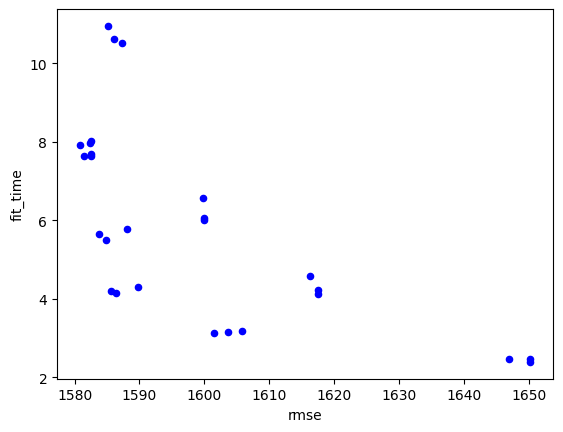

In [67]:
lgbm_models_df.plot.scatter(x='rmse',
                      y='fit_time',
                      c='Blue');

Нас интересует левый нижний угол графика - минимальная ошибка и время обучения.

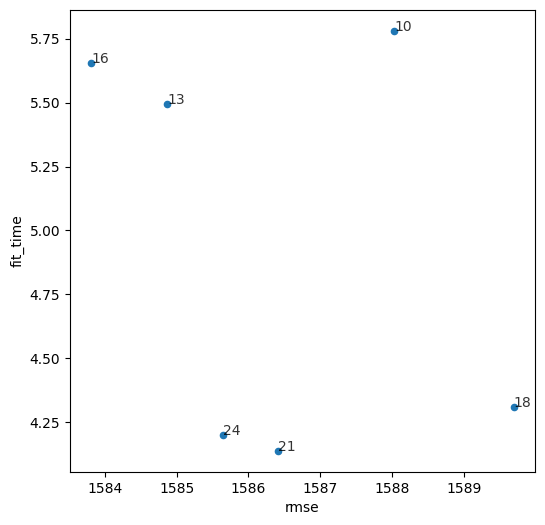

In [69]:
#create scatter plot of assists vs. points
best_lgbm_models_df = lgbm_models_df[(lgbm_models_df['rmse'] < 1600) &(lgbm_models_df['fit_time'] < 6)]
ax = best_lgbm_models_df.plot(kind='scatter', x='rmse', y='fit_time',figsize=(6,6))

#label each point in scatter plot
for idx, row in best_lgbm_models_df.iterrows():
    ax.annotate(idx, (row['rmse'], row['fit_time']), alpha=0.8)

Самые лучшие модели - номер 16, 24, 21. Выделим их для будущего сравнения.

In [70]:
best_lgbm_models_df = lgbm_models_df.loc[[16, 24, 21]].reset_index(drop=True)
best_lgbm_models_df

,model,rmse,fit_time,predict_time,num_leaves,max_depth,n_estimators
0,"LGBMRegressor(max_depth=50, n_estimators=1000,...",1583.811155,5.655751,1.157149,50,50,1000
1,"LGBMRegressor(max_depth=50, n_estimators=500, ...",1585.641661,4.200663,0.781123,100,50,500
2,"LGBMRegressor(max_depth=20, n_estimators=500, ...",1586.416796,4.139236,0.781162,100,20,500


### Модель CatBoost

In [71]:
cat_features = ['vehicle_type','gearbox','fuel_type','repaired','model', 'brand']

In [72]:
cat_models = []

In [73]:
%%time
start = time.time()
iterationss = [100, 150, 200]
learning_rates = [0.03, 0.1]
depths = [6, 8, 10]
for iterations in iterationss:
    for learning_rate in learning_rates:
        for depth in depths:
            start = time.time()
            model = CatBoostRegressor(loss_function='RMSE',
                                      iterations=iterations,
                                      depth=depth,
                                      cat_features=cat_features,
                                      random_seed=random_state)
            model.fit(x_train, y_train,verbose=0)
            end = time.time()
            fit_time = end - start
            start = time.time()
            prediction = model.predict(x_valid)
            rmse = mean_squared_error(y_valid, prediction) ** 0.5
            end = time.time()
            predict_time = end - start
            cat_models.append([
                model, rmse, fit_time, predict_time, iterations, depth, learning_rate                   
            ])

CPU times: total: 27min 6s
Wall time: 7min 58s


In [74]:
cat_models_df = pd.DataFrame(cat_models)
cat_models_df.columns = ['model', 'rmse', 'fit_time', 'predict_time', 'iterations', 'depth','learning_rate']

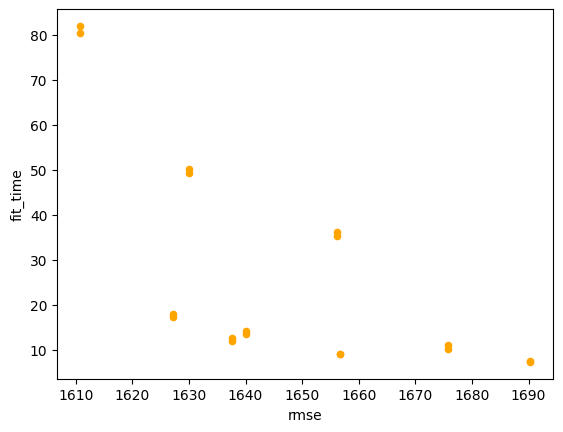

In [75]:
cat_models_df.plot.scatter(x='rmse',
                      y='fit_time',
                      c='Orange');

Нас интересует левый нижний угол графика - минимальная ошибка и время обучения.

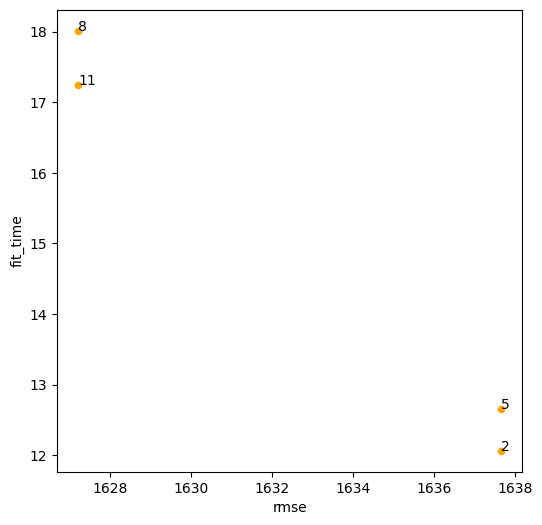

In [77]:
#create scatter plot of assists vs. points
best_cat_models_df = cat_models_df[(cat_models_df['rmse'] < 1640) &(cat_models_df['fit_time'] < 20)]
ax = best_cat_models_df.plot(kind='scatter', x='rmse', y='fit_time',figsize=(6,6),c='Orange')

#label each point in scatter plot
for idx, row in best_cat_models_df.iterrows():
    ax.annotate(idx, (row['rmse'], row['fit_time']))

Самые интересные модели с номерами 11, 2. 

In [78]:
best_cat_models_df = cat_models_df.loc[[11, 2]].reset_index(drop=True)
best_cat_models_df

,model,rmse,fit_time,predict_time,iterations,depth,learning_rate
0,<catboost.core.CatBoostRegressor object at 0x0...,1627.216673,17.248540,0.156244,150,10,0.10
1,<catboost.core.CatBoostRegressor object at 0x0...,1637.647928,12.064801,0.181548,100,10,0.03


Эти модели позднее сравним с другими моделями.

### Модель LinearRegression

In [79]:
%%time
start = time.time()
model = LinearRegression()
model.fit(x_train_ohe, y_train)
end = time.time()
fit_time = end - start
start = time.time()
prediction = model.predict(x_valid_ohe)
rmse = mean_squared_error(y_valid, prediction) ** 0.5
end = time.time()
predict_time = end - start

CPU times: total: 5.02 s
Wall time: 5.12 s


In [80]:
linear_model_df = pd.DataFrame([[model, rmse, fit_time, predict_time]])

In [81]:
linear_model_df.columns = ['model', 'rmse','fit_time','predict_time']
linear_model_df

,model,rmse,fit_time,predict_time
0,LinearRegression(),2024.905241,5.118434,0.003006


### Модель RandomForest

In [82]:
forest_models = []

In [83]:
%%time
for est in range(10, 51, 10):
    for depth in range(1,11):
        start = time.time()
        model = RandomForestRegressor(n_estimators=est, 
                                       max_depth=depth, 
                                       random_state=random_state)
        model.fit(x_train_oe, y_train)
        end = time.time()
        fit_time = end - start
        start = time.time()
        prediction = model.predict(x_valid_oe)
        rmse = mean_squared_error(y_valid, prediction) ** 0.5
        end = time.time()
        predict_time = end - start
        forest_models.append([
            model, rmse, fit_time, predict_time, est, depth                 
        ])

CPU times: total: 5min 17s
Wall time: 5min 22s


In [84]:
forest_models_df = pd.DataFrame(forest_models)
forest_models_df.columns = ['model', 'rmse', 'fit_time', 'predict_time', 'n_estimators', 'depth']

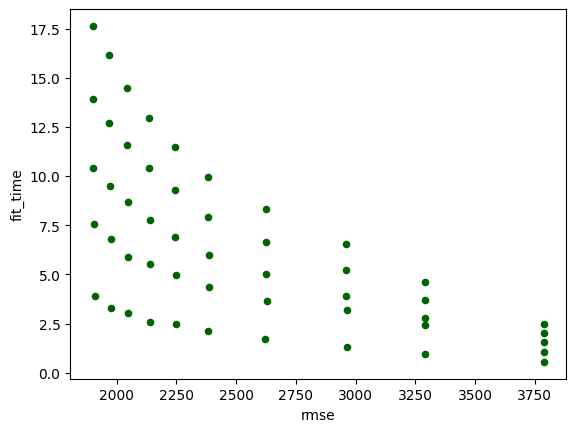

In [85]:
forest_models_df.plot.scatter(x='rmse',
                      y='fit_time',
                      c='DarkGreen');

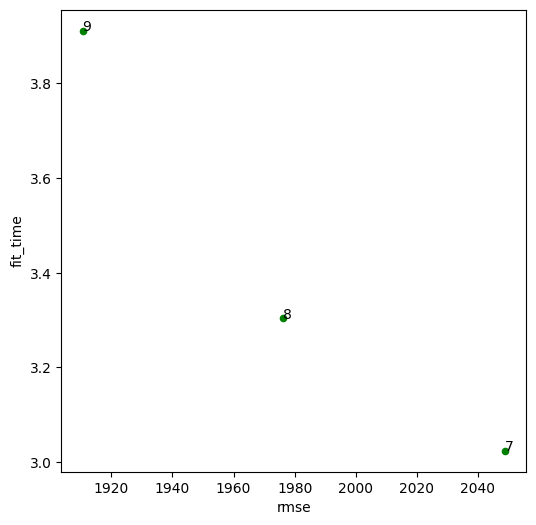

In [86]:
#create scatter plot of assists vs. points
best_forest_models_df = forest_models_df[(forest_models_df['rmse'] < 2100) &(forest_models_df['fit_time'] < 5)]
ax = best_forest_models_df.plot(kind='scatter', x='rmse', y='fit_time',figsize=(6,6),c='Green')

#label each point in scatter plot
for idx, row in best_forest_models_df.iterrows():
    ax.annotate(idx, (row['rmse'], row['fit_time']))

Эти три модели оставим для дальнейшего анализа.

## Анализ моделей

Сравним теперь все сохранённые ранее модели.

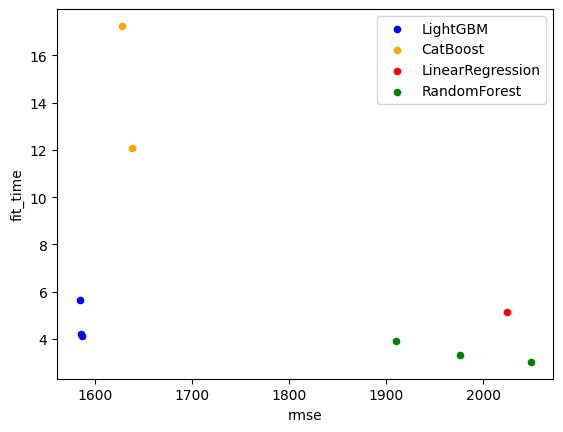

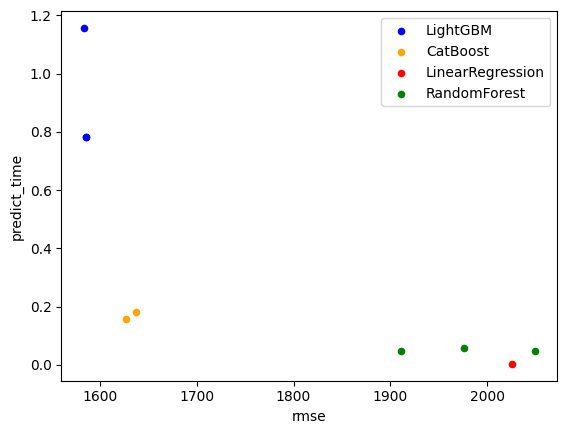

In [87]:
ax = best_lgbm_models_df.plot(kind='scatter', x='rmse', y='fit_time',c='Blue',label='LightGBM')
best_cat_models_df.plot(ax=ax, kind='scatter', x='rmse', y='fit_time',c='Orange',label='CatBoost')
linear_model_df.plot(ax=ax, kind='scatter', x='rmse', y='fit_time',c='Red',label='LinearRegression')
best_forest_models_df.plot(ax=ax, kind='scatter', x='rmse', y='fit_time',c='Green',label='RandomForest')
plt.show();
ax = best_lgbm_models_df.plot(kind='scatter', x='rmse', y='predict_time',c='Blue',label='LightGBM')
best_cat_models_df.plot(ax=ax, kind='scatter', x='rmse', y='predict_time',c='Orange',label='CatBoost')
linear_model_df.plot(ax=ax, kind='scatter', x='rmse', y='predict_time',c='Red',label='LinearRegression')
best_forest_models_df.plot(ax=ax, kind='scatter', x='rmse', y='predict_time',c='Green',label='RandomForest')
plt.show();

**LightGbm:**  
* RMSE примерно 1585 - лучший результат
* Время обучения 4-6 секунд - второй результат
* Время предсказания 0.8 - 1.2 секунд - худший результат
  
**CatBoost**
* RMSE примерно 1650 - второй результат
* Время обучения 12-17 секунд - худший результат
* Время предсказания 0.2 секунды - третий результат
  
**LinearRegression**
* RMSE примерно 2025 - худший результат
* Время обучения 5 секунд - второй результат
* Время предсказания 0.003 секунды - лучший результат 

**RandomForest**
* RMSE примерно 1900-2100 - третий результат
* Время обучения примерно 3-4 секунды - лучший результат
* Время предсказания 0.1 секунды - второй результат

Я выбираю лучшей модель **CatBoost**.  
CatBoost покзала худшее время обучения, однако обучение проводится несколько раз или даже всего один. А предсказания проводятся гораздо чаще.   
LightGBM показал слишком плохое время предсказания - примерно в 5 раз дольше, чем CatBoost. При этом метрика RMSE лучше всего на 4%.   
LinearRegression и RandomForest показали слишком низкое значение метрики RMSE.

In [88]:
best_cat_models_df

,model,rmse,fit_time,predict_time,iterations,depth,learning_rate
0,<catboost.core.CatBoostRegressor object at 0x0...,1627.216673,17.248540,0.156244,150,10,0.10
1,<catboost.core.CatBoostRegressor object at 0x0...,1637.647928,12.064801,0.181548,100,10,0.03


Из двух моделей CatBoost я выбираю модель с меньшим временем обучения и предсказания.  
Время обучения у неё лучше на 34%, при этом RMSE хуже примерно на 1%.

In [89]:
best_model = best_cat_models_df.loc[1,'model']

Проверим теперь нашу модель на тестовых данных. 

In [90]:
%%time
prediction = best_model.predict(x_test)
mean_squared_error(y_test, prediction) ** 0.5

CPU times: total: 375 ms
Wall time: 226 ms


1627.3049018397824

RMSE = 1627, даже лучше, чем на валидационных данных. 🤔    
Время предсказания 0.23 секунды, немного хуже (сравнивать можно, так как размеры тестовой и валидационной выборки одинаковые).

<font size=3>
Лучшая модель:
 
CatBoost
<ul>
<li> RMSE = 1627</li>
<li> Время обучения  = 12 сек.(179004 строк данных)	</li>
<li> Время предсказания = 0.23 сек.(59669 строк данных)</li>	
<li> Число деревьев = 100	</li>
<li> Глубина деревьев = 10	</li>
<li> Коэффициент скорости обучения = 0.03</li>